<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Predicting West Nile Virus in Mosquitoes

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import time
import re
import datetime
import random
import pickle
import geopandas as gpd
from shapely.geometry import Point, Polygon
from matplotlib import dates, cm

pd.set_option('display.max_columns', 50)
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# import shape file for city of Chicago
# downloaded from https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-City/ewy2-6yfk
street_map = gpd.read_file('../assets/geo_export_a6957f22-b168-4cee-b03c-0bcc9815308c.shp')

In [3]:
train = pd.read_csv('../assets/train.csv/train.csv')
train['Date'] = pd.to_datetime(train['Date'])
train['year'] = train['Date'].dt.year

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  year                    10506 non-null  int64 

In [5]:
round(train.groupby(train['Date'].dt.year)['WnvPresent'].value_counts(normalize=True), 2)

Date  WnvPresent
2007  0             0.94
      1             0.06
2009  0             0.99
      1             0.01
2011  0             0.97
      1             0.03
2013  0             0.90
      1             0.10
Name: WnvPresent, dtype: float64

In [6]:
train['Date'].dt.year.value_counts().sort_index()

2007    3811
2009    2249
2011    2054
2013    2392
Name: Date, dtype: int64

We observe a U-shaped pattern for the positivity rate - 6% in 2007, 1% in 2009, 3% in 2011 and 10% in 2013. This explains the same shape for the number of tests done over the years, which probably correlates with the actual number of reported WNV cases over time.

In [7]:
round(train.groupby(train['Date'].dt.month)['WnvPresent'].value_counts(normalize=True), 2)

Date  WnvPresent
5     0             1.00
6     0             1.00
      1             0.00
7     0             0.98
      1             0.02
8     0             0.90
      1             0.10
9     0             0.94
      1             0.06
10    0             0.99
      1             0.01
Name: WnvPresent, dtype: float64

In [8]:
train['Date'].dt.month.value_counts().sort_index()

5       84
6     1571
7     2606
8     3751
9     2218
10     276
Name: Date, dtype: int64

More tests are done in Sep-Oct which also yields higher positivity rate, probably due to higher reported numbers of WNV cases. Because of the lack of testing data in other months, predictions for those months may not be accurate

In [9]:
# create a point for every lat-long combination
geometry = [Point(xy) for xy in zip(train['Longitude'], train['Latitude'])]

In [10]:
# create gpd DataFrame
geo_train = gpd.GeoDataFrame(train,
                            crs={'init': 'epsg:4326'},
                             geometry=geometry)
geo_train.head()

C:\Users\Darre\.conda\envs\geoenv\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,year,geometry
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,POINT (-87.80099 41.95469)
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,POINT (-87.80099 41.95469)
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,2007,POINT (-87.76928 41.99499)
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,2007,POINT (-87.82481 41.97409)
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,2007,POINT (-87.82481 41.97409)


In [11]:
# Groupby address to aggregate "density" of WNV at each location. Density can be high due to many detections over time or a single detection
# with large concentration of positive mosquitos, hence across time and batch
geo_train_groupby = geo_train.dissolve(by='Address', aggfunc='sum')
geo_train_groupby.head(3)

,geometry,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,year
Address,,,,,,,,
"1000 East 67th Street, Chicago, IL 60637, USA",POINT (-87.60088 41.77322),1280,5346.971520,-11212.912640,1024,852,4,257258
"1000 North Central Park Avenue, Chicago, IL 60651, USA",POINT (-87.71679 41.89923),1260,5279.302980,-11052.315288,1134,1802,8,253298
"1000 South California Avenue, Chicago, IL 60612, USA",POINT (-87.69629 41.86911),280,1172.334996,-2455.496204,252,125,0,56196


The count of WNVPresent indicates the density. As the dataset consists  of multiple years and multiple batches, the value has no interpretable meaning but provides a relative value about its "hotness" as a cluster. For example, 4 could mean that there were 4 batches of mosquitos returning positive in one day, or 1 batch of mosquito every year over 4 years. Hence, the value provides a rough sense of how prone it is to WNV.

# Where are the traps and which traps have returned positive

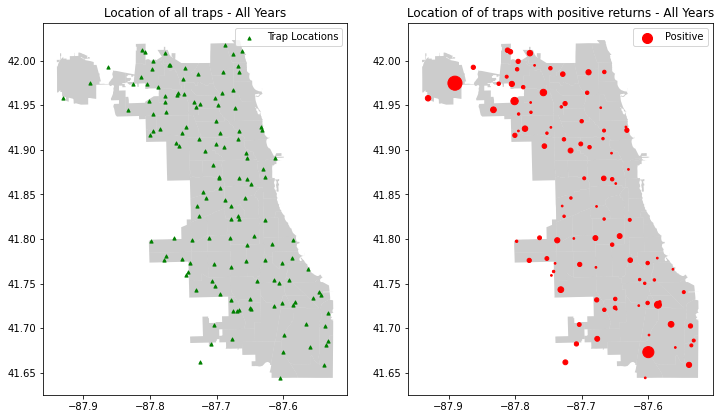

In [12]:
fig,ax = plt.subplots(figsize=(12,12), nrows=1, ncols=2)

# Chicago background
street_map.plot(ax=ax[0], alpha=0.4, color='grey')
street_map.plot(ax=ax[1], alpha=0.4, color='grey')

# Plot locations where WNV is detected. Size of marker indicates density
geo_train_groupby[geo_train_groupby['WnvPresent']>0].plot(ax=ax[1], color='red', marker='o', label='Positive', markersize = (geo_train_groupby[geo_train_groupby['WnvPresent']>0]['WnvPresent']*3).values)

# Plot locations of all traps
geo_train_groupby.plot(ax=ax[0], markersize=10, color='green', marker='^', label='Trap Locations')
ax[0].legend()
ax[0].set_title('Location of all traps - All Years')
ax[1].legend()
ax[1].set_title('Location of of traps with positive returns - All Years')

fig.savefig('../charts/01.jpg')

No discernible pattern of spread, though some neighborhoods have a higher density of infected mosquitos. Most traps return positive at least once throughout the years. The two densest clusters is at ORD airport and near a water reclamation plant at South Doty Avenue.

Airplanes are known to be a vessel for mosquitos to travel. Given that ORD airport is international and has a much higher passenger flow than Midway airport, this could be reasons why a cluster could form there. It could also receive passengers from all over the world, some of whom may already been infected by the virus.

As for the water reclamation plant, due to the fact that it is sited near large bodies of water, mosquito breeding grounds could be abundant.

# Is there a pattern of positive returns over time?

In [13]:
# create 1 dataframe, 1 for each year
geo_train_groupby_2007_WNV = geo_train[geo_train['Date'].dt.year==2007].dissolve(by='Address', aggfunc='sum')
geo_train_groupby_2007_WNV = geo_train_groupby_2007_WNV[geo_train_groupby_2007_WNV['WnvPresent'] > 0]

geo_train_groupby_2009_WNV = geo_train[geo_train['Date'].dt.year==2009].dissolve(by='Address', aggfunc='sum')
geo_train_groupby_2009_WNV = geo_train_groupby_2009_WNV[geo_train_groupby_2009_WNV['WnvPresent'] > 0]

geo_train_groupby_2011_WNV = geo_train[geo_train['Date'].dt.year==2011].dissolve(by='Address', aggfunc='sum')
geo_train_groupby_2011_WNV = geo_train_groupby_2011_WNV[geo_train_groupby_2011_WNV['WnvPresent'] > 0]

geo_train_groupby_2013_WNV = geo_train[geo_train['Date'].dt.year==2013].dissolve(by='Address', aggfunc='sum')
geo_train_groupby_2013_WNV = geo_train_groupby_2013_WNV[geo_train_groupby_2013_WNV['WnvPresent'] > 0]

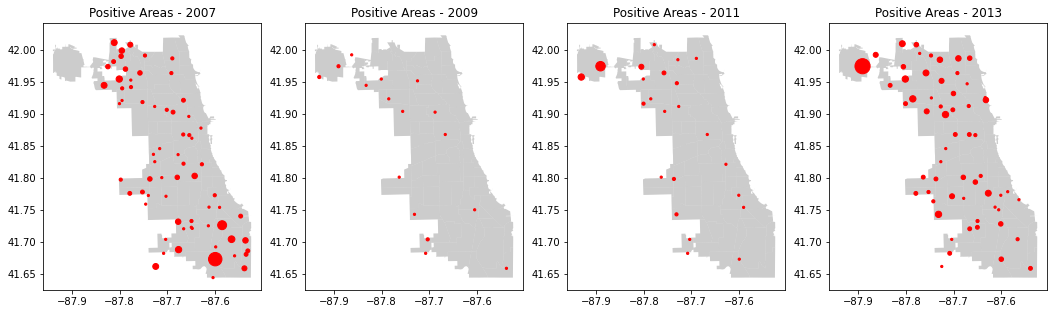

In [14]:
fig,ax = plt.subplots(figsize=(18,18), nrows=1, ncols=4)
street_map.plot(ax=ax[0], alpha=0.4, color='grey')
street_map.plot(ax=ax[1], alpha=0.4, color='grey')
street_map.plot(ax=ax[2], alpha=0.4, color='grey')
street_map.plot(ax=ax[3], alpha=0.4, color='grey')

geo_train_groupby_2007_WNV.plot(ax=ax[0], markersize=(geo_train_groupby_2007_WNV['WnvPresent']*5).values, color='red', marker='o')
ax[0].set_title('Positive Areas - 2007')

geo_train_groupby_2009_WNV.plot(ax=ax[1], markersize=(geo_train_groupby_2009_WNV['WnvPresent']*5).values, color='red', marker='o')
ax[1].set_title('Positive Areas - 2009')

geo_train_groupby_2011_WNV.plot(ax=ax[2], markersize=(geo_train_groupby_2011_WNV['WnvPresent']*5).values, color='red', marker='o')
ax[2].set_title('Positive Areas - 2011')

geo_train_groupby_2013_WNV.plot(ax=ax[3], markersize=(geo_train_groupby_2013_WNV['WnvPresent']*5).values, color='red', marker='o')
ax[3].set_title('Positive Areas - 2013')

fig.savefig('../charts/02.jpg')

There was quite the outbreak in starting in 2007, with concentrations in the north and south of Chicago. Miraculously, positivity rates plunged in 2009, but continued to grow since then, especially ORD airport in the North-West, where the cluster grew larger over time.

It seems that there is some sort of cyclical pattern. It cannot be weather because there is no substantial difference in climate in 2009 and 2011 compared to 2007 and 2013 driving the infection. This is likely man-made effect where perhaps due to some drastic measures undertaken by the city (what?) to curb the virus transmission after 2007.

Variable: WNV Density equal to value at that address in the current/preceding year. Current year for training the model with the training data, preceding year for predictions on the test dataset.

This is to account for the time - a hotspot in 2007 may no longer be a hotspot in 2013. That said, there could still be fluctuations within months, weeks and days, but we will not dive at the level to keep our model simple.

In [15]:
wnv_density_year = geo_train.dissolve(by=['year', 'Address'], aggfunc='sum')['WnvPresent']
wnv_density_year.to_csv('../assets/processed_data/wnv_density_processed.csv')

# Does higher number of mosquitos affect probability of WNV present?

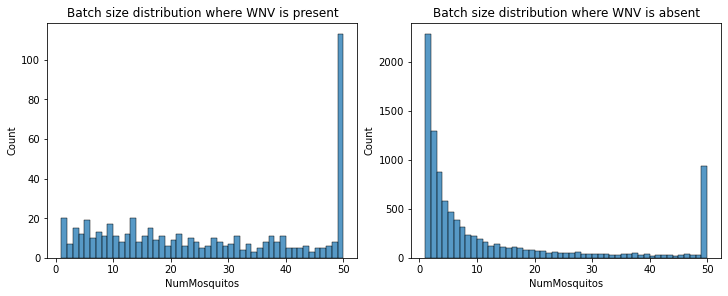

In [16]:
fig,ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10,4))
sns.histplot(data=geo_train[geo_train['WnvPresent']==1], binwidth=1, x='NumMosquitos', ax=ax[0])
ax[0].set_title('Batch size distribution where WNV is present')
sns.histplot(data=geo_train[geo_train['WnvPresent']==0], binwidth=1, x='NumMosquitos', ax=ax[1])
ax[1].set_title('Batch size distribution where WNV is absent')

fig.savefig('../charts/03.jpg')

From the left graph, most of the WNV occurs when batch size is 50. This is expected, since higher numbers of mosquitos means higher likelihood of disease transmission. Unfortunately, we cannot use this as a predictor as this information is not available in the test set.

# Which months have higher WNV occurrences?

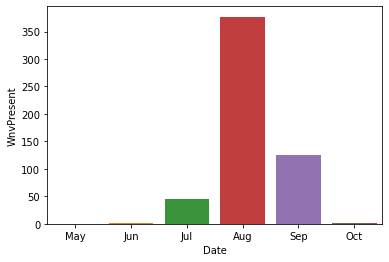

In [17]:
date_groupby = geo_train.groupby(geo_train['Date'].dt.month)['WnvPresent'].sum().reset_index()
date_groupby['Date'] = date_groupby['Date'].map({5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct'})
sns.barplot(data=date_groupby, x='Date', y='WnvPresent')

plt.savefig('../charts/04.jpg')

Jul, Aug and Sep are the hottest months for transmission of WNV, as we saw earlier. This is probably attributed to weather conditions (see below) where these months tend to be warmer and more humid.

Variable: month

# Which species of mosquitos carry WNV?

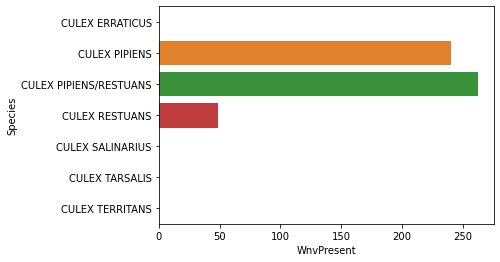

In [18]:
species_groupby = geo_train.groupby('Species')['WnvPresent'].sum().reset_index()
sns.barplot(data=species_groupby, y='Species', x='WnvPresent', orient='h')
plt.savefig('../charts/05.jpg')

Only Pipiens and Restuans subspecies have been detected with the virus. However this doesn't mean that the other subspecies are unable to carry the virus. If this turns out to be so in future, our model would be extremely poor at predicting these subspecies because it has never observed such cases before in our training data.

Variable: Species of mosquito

# Sprays

In [19]:
spray = pd.read_csv('../assets/spray.csv/spray.csv')
spray['Date'] = pd.to_datetime(spray['Date'])
spray = spray[spray['Latitude'] < 42.3] # remove outliers outside of Chicago
spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14740 entries, 95 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       14740 non-null  datetime64[ns]
 1   Time       14156 non-null  object        
 2   Latitude   14740 non-null  float64       
 3   Longitude  14740 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 575.8+ KB


In [20]:
spray['Date'].dt.month.value_counts().sort_index()

7    3809
8    7893
9    3038
Name: Date, dtype: int64

Alot more sprays done in August - expected since transmission spikes in August.

In [21]:
geometry_spray = [Point(xy) for xy in zip(spray['Longitude'], spray['Latitude'])]

In [22]:
geo_spray = gpd.GeoDataFrame(spray,
                            crs={'init': 'epsg:4326'},
                             geometry=geometry_spray)
geo_spray.head()

C:\Users\Darre\.conda\envs\geoenv\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,Date,Time,Latitude,Longitude,geometry
95,2011-09-07,7:52:52 PM,41.981433,-87.787777,POINT (-87.78778 41.98143)
96,2011-09-07,7:53:02 PM,41.980998,-87.787778,POINT (-87.78778 41.98100)
97,2011-09-07,7:53:12 PM,41.980560,-87.787762,POINT (-87.78776 41.98056)
98,2011-09-07,7:53:22 PM,41.980198,-87.787758,POINT (-87.78776 41.98020)
99,2011-09-07,7:53:32 PM,41.979752,-87.787765,POINT (-87.78776 41.97975)


In [23]:
geo_spray_2011 = geo_spray[geo_spray['Date'].dt.year==2011]
geo_spray_2013 = geo_spray[geo_spray['Date'].dt.year==2013]

# Spray juxtaposed Positive Traps

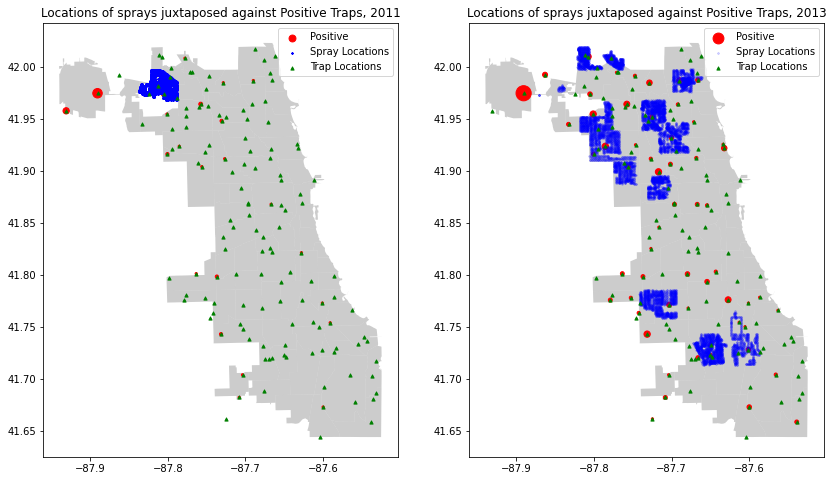

In [41]:
fig,ax = plt.subplots(figsize=(14,14), ncols=2)
street_map.plot(ax=ax[0], alpha=0.4, color='grey')
street_map.plot(ax=ax[1], alpha=0.4, color='grey')

geo_train_groupby_2011_WNV.plot(ax=ax[0], markersize=(geo_train_groupby_2011_WNV['WnvPresent']*5).values, color='red', marker='o', label='Positive')
geo_spray_2011.plot(ax=ax[0], markersize=3, color='blue', marker='x', label='Spray Locations', alpha=0.2)
geo_train_groupby.plot(ax=ax[0], markersize=10, color='green', marker='^', label='Trap Locations')
ax[0].legend()
ax[0].set_title('Locations of sprays juxtaposed against Positive Traps, 2011')

geo_train_groupby_2013_WNV.plot(ax=ax[1], markersize=(geo_train_groupby_2013_WNV['WnvPresent']*5).values, color='red', marker='o', label='Positive')
geo_spray_2013.plot(ax=ax[1], markersize=3, color='blue', marker='x', label='Spray Locations', alpha=0.2)
geo_train_groupby.plot(ax=ax[1], markersize=10, color='green', marker='^', label='Trap Locations')
ax[1].legend()
ax[1].set_title('Locations of sprays juxtaposed against Positive Traps, 2013')

fig.savefig('../charts/06.jpg')

We see that in 2011, spraying was only conducted in 1 particular neighborhood, wherelse in 2013 efforts expanded significantly to more neighborhoods. This suggests a reactive approach taken by city council - to only step up spraying when positivity rates increase and/or actual reported cases increase. We can see that spraying does help somewhat, where the traps within the spray zone turn up negative after spraying.

Variable: whether location is near a coordinate earmarked for spraying. Since we do not have spray data for all the years, we can only assume that these locations were sprayed because the authorities had some intelligence that these are the hot spots.

While spraying would definitely have a strong correlation as to whether WNV is present, this variable may or may not be useful due to the time lag in making predictions.

In [25]:
# Take distinct latitude and longitude - if present, shows that the location has been earmarked for spraying, indicating hot spots
spray[['Latitude', 'Longitude']].drop_duplicates(subset=['Latitude', 'Longitude']).shape

(14199, 2)

In [26]:
# used for feature engineering later
spray[['Latitude', 'Longitude']].drop_duplicates(subset=['Latitude', 'Longitude']).to_csv('../assets/processed_data/spray_processed.csv', index=False)

# Weather

From [Wikipedia](https://en.wikipedia.org/wiki/West_Nile_virus), we know that the epidemiology of WNV is dependent on:
- Humidity (higher favors WNV)
- Temperature (higher favors mosquito replication, WNV replication and efficiency)
- Precipitation (higher favors WNV)
- Wind Speed (higher favors dispersal of mosquitos)

Variables:
- DewPoint
- WetBulb
- Tavg
- AvgSpeed
- PrecipTotal

In [27]:
# Function to fill missing data. For columns with missing data, we will use the average data of D-1 and D+1. If D-1 and D+1 also results
# in missing, then go back/forward one more day until non-missing data is available
def find_average_value(main_df, index, column):
    
    station_missing = index['Station']
    
    # D-1, or when data is available
    i = -1
    date_missing_prev = index['Date'] + pd.Timedelta(days=-1)
    while main_df[(main_df['Station']==station_missing) & (main_df['Date']==date_missing_prev)][column].values[0] == 'M':
        i -= 1
        date_missing_prev = index['Date'] + pd.Timedelta(days=i)
    
    # D+1, or when data is available
    j = 1
    date_missing_next = index['Date'] + pd.Timedelta(days=1)
    while main_df[(main_df['Station']==station_missing) & (main_df['Date']==date_missing_next)][column].values[0] == 'M':
        j += 1
        date_missing_next = index['Date'] + pd.Timedelta(days=j)
        
    # value of the column at D-x    
    prev_row_value = main_df[(main_df['Station']==station_missing) & (main_df['Date']==date_missing_prev)][column].values[0]
    # value of the column at D+x
    next_row_value = main_df[(main_df['Station']==station_missing) & (main_df['Date']==date_missing_next)][column].values[0]

    # average of both values
    return (float(prev_row_value) + float(next_row_value))/2

In [28]:
weather = pd.read_csv('../assets/weather.csv/weather.csv')
weather['Date'] = pd.to_datetime(weather['Date'])

# Fill non-numeric values
# If T, replace with 0. If M, replace with function defined earlier
weather['PrecipTotal'] = weather['PrecipTotal'].apply(lambda x: 0 if x == '  T' else x)
weather['Tavg'] = weather.apply(lambda x: (float(x['Tmax']) + float(x['Tmin']))/2 if x['Tavg'] == 'M' else x['Tavg'], axis=1)
weather['WetBulb'] = weather.apply(lambda x: find_average_value(weather, x, 'WetBulb') if x['WetBulb'] == 'M' else x['WetBulb'], axis=1)
weather['PrecipTotal'] = weather.apply(lambda x: find_average_value(weather, x, 'PrecipTotal') if x['PrecipTotal'] == 'M' else x['PrecipTotal'], axis=1)
weather['AvgSpeed'] = weather.apply(lambda x: find_average_value(weather, x, 'AvgSpeed') if x['AvgSpeed'] == 'M' else x['AvgSpeed'], axis=1)

# Convert to float
weather['DewPoint'] = weather['DewPoint'].astype(float)
weather['WetBulb'] = weather['WetBulb'].astype(float)
weather['Tavg'] = weather['Tavg'].astype(float)
weather['PrecipTotal'] = weather['PrecipTotal'].astype(float)
weather['AvgSpeed'] = weather['AvgSpeed'].astype(float)

# split into station 1 and 2 to see if there are substantial differences in readings
weather1 = weather[weather['Station']==1]
weather1['yearmonth'] = weather1['Date'].values.astype('datetime64[M]')
weather1['Latitude'] = 41.995
weather1['Longitude'] = -87.933

weather2 = weather[weather['Station']==2]
weather2['yearmonth'] = weather2['Date'].values.astype('datetime64[M]')
weather2['Latitude'] = 41.786
weather2['Longitude'] = -87.752

In [29]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   float64       
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   float64       
 7   WetBulb      2944 non-null   float64       
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [30]:
weather1.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,yearmonth,Latitude,Longitude
0,1,2007-05-01,83,50,67.0,14,51.0,56.0,0,2,0448,1849,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2,2007-05-01,41.995,-87.933
2,1,2007-05-02,59,42,51.0,-3,42.0,47.0,14,0,0447,1850,BR,0,M,0.0,0.0,29.38,30.09,13.0,4,13.4,2007-05-01,41.995,-87.933
4,1,2007-05-03,66,46,56.0,2,40.0,48.0,9,0,0446,1851,,0,M,0.0,0.0,29.39,30.12,11.7,7,11.9,2007-05-01,41.995,-87.933
6,1,2007-05-04,66,49,58.0,4,41.0,50.0,7,0,0444,1852,RA,0,M,0.0,0.0,29.31,30.05,10.4,8,10.8,2007-05-01,41.995,-87.933
8,1,2007-05-05,66,53,60.0,5,38.0,49.0,5,0,0443,1853,,0,M,0.0,0.0,29.40,30.10,11.7,7,12.0,2007-05-01,41.995,-87.933


In [31]:
weather1_groupby = weather1.groupby('yearmonth').agg({
                                                        'DewPoint': 'mean',
                                                        'WetBulb': 'mean',
                                                        'Tavg': 'mean',
                                                        'PrecipTotal': 'sum',
                                                        'AvgSpeed': 'mean'
                                                    })
weather1_groupby.head()

,DewPoint,WetBulb,Tavg,PrecipTotal,AvgSpeed
yearmonth,,,,,
2007-05-01,45.774194,54.387097,64.000000,1.80,10.348387
2007-06-01,56.566667,62.766667,71.566667,2.29,8.860000
2007-07-01,58.967742,64.645161,74.000000,3.86,7.867742
2007-08-01,64.032258,68.032258,75.064516,9.70,6.880645
2007-09-01,53.100000,59.600000,68.266667,1.23,8.866667


In [32]:
# Find monthly weather statistics, since daily might result in alot of variance which is not very useful
weather2_groupby = weather2.groupby('yearmonth').agg({
                                                        'DewPoint': 'mean',
                                                        'WetBulb': 'mean',
                                                        'Tavg': 'mean',
                                                        'PrecipTotal': 'sum',
                                                        'AvgSpeed': 'mean'
                                                    })
weather2_groupby.head()

,DewPoint,WetBulb,Tavg,PrecipTotal,AvgSpeed
yearmonth,,,,,
2007-05-01,45.806452,54.774194,65.241935,1.78,9.967742
2007-06-01,56.633333,63.200000,72.833333,3.26,8.550000
2007-07-01,58.709677,64.870968,74.387097,3.11,8.316129
2007-08-01,64.161290,68.290323,75.709677,8.69,6.919355
2007-09-01,53.000000,60.200000,69.566667,1.29,8.853333


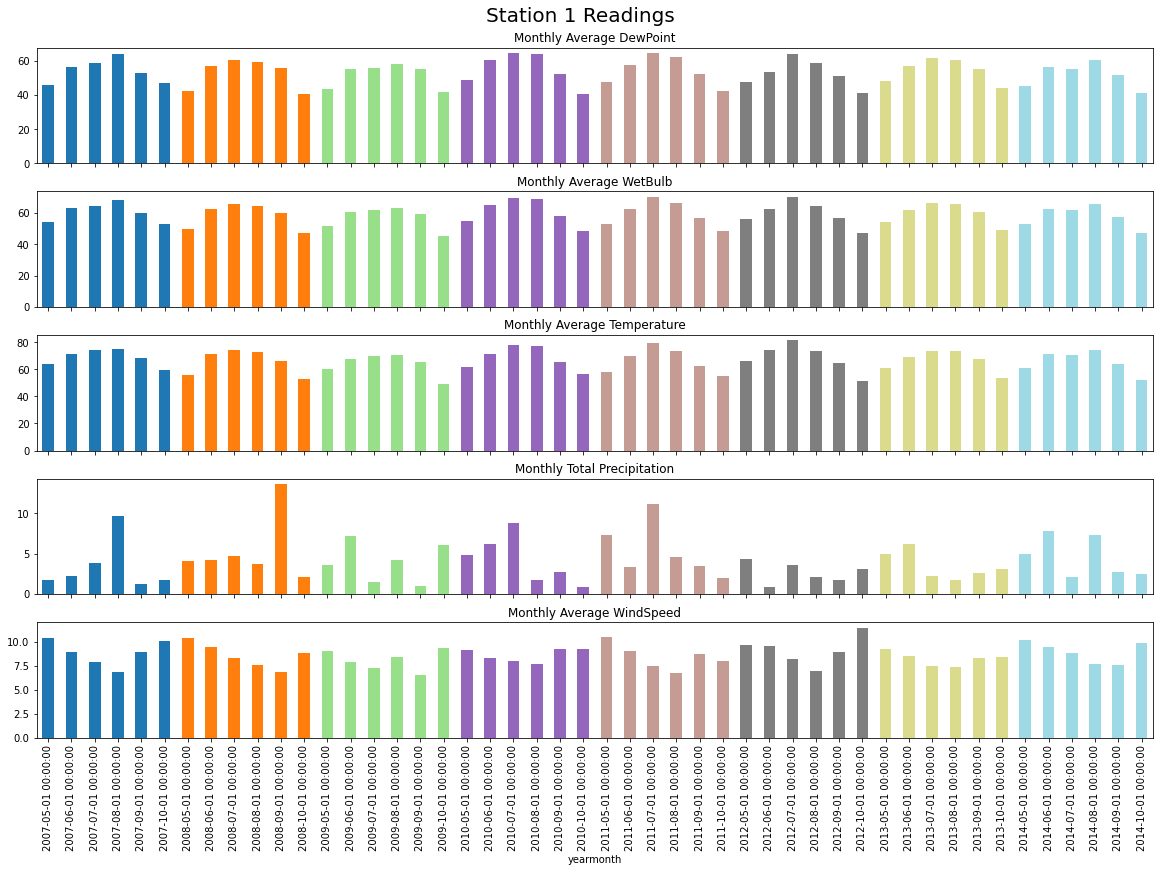

In [33]:
fig,ax = plt.subplots(figsize=(16,12), nrows=5, sharex=True, constrained_layout=True)
fig.suptitle('Station 1 Readings', fontsize=20)

# create array of colors, 1 for each year, to separate bars by year
yrs = np.unique(weather1_groupby.index.year)
c = cm.get_cmap('tab20', len(yrs))
yrClr = np.zeros((len(weather1_groupby.index.year),4))
for i, v in enumerate(yrs): 
    yrClr[weather1_groupby.index.year==v,:]=c.colors[i,:]

ax[0] = weather1_groupby['DewPoint'].plot(kind='bar', color=yrClr, ax=ax[0])
ax[0].set_title('Monthly Average DewPoint')

ax[1] = weather1_groupby['WetBulb'].plot(kind='bar', color=yrClr, ax=ax[1])
ax[1].set_title('Monthly Average WetBulb')

ax[2] = weather1_groupby['Tavg'].plot(kind='bar', color=yrClr, ax=ax[2])
ax[2].set_title('Monthly Average Temperature')

ax[3] = weather1_groupby['PrecipTotal'].plot(kind='bar', color=yrClr, ax=ax[3])
ax[3].set_title('Monthly Total Precipitation')

ax[4] = weather1_groupby['AvgSpeed'].plot(kind='bar', color=yrClr, ax=ax[4])
ax[4].set_title('Monthly Average WindSpeed')

fig.savefig('../charts/07.jpg')

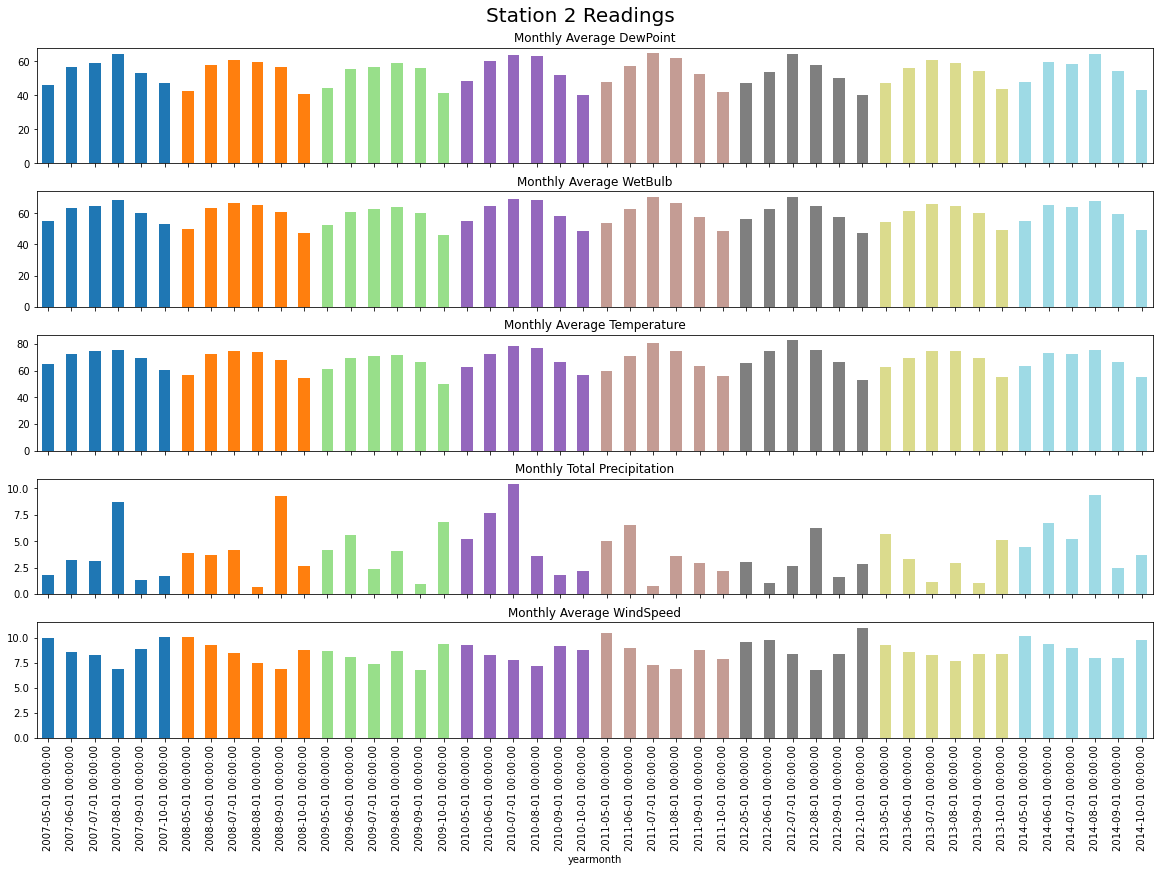

In [34]:
fig,ax = plt.subplots(figsize=(16,12), nrows=5, sharex=True, constrained_layout=True)
fig.suptitle('Station 2 Readings', fontsize=20)

yrs = np.unique(weather2_groupby.index.year)
c = cm.get_cmap('tab20', len(yrs))
yrClr = np.zeros((len(weather2_groupby.index.year),4))
for i, v in enumerate(yrs): 
    yrClr[weather2_groupby.index.year==v,:]=c.colors[i,:]

ax[0] = weather2_groupby['DewPoint'].plot(kind='bar', color=yrClr, ax=ax[0])
ax[0].set_title('Monthly Average DewPoint')

ax[1] = weather2_groupby['WetBulb'].plot(kind='bar', color=yrClr, ax=ax[1])
ax[1].set_title('Monthly Average WetBulb')

ax[2] = weather2_groupby['Tavg'].plot(kind='bar', color=yrClr, ax=ax[2])
ax[2].set_title('Monthly Average Temperature')

ax[3] = weather2_groupby['PrecipTotal'].plot(kind='bar', color=yrClr, ax=ax[3])
ax[3].set_title('Monthly Total Precipitation')

ax[4] = weather2_groupby['AvgSpeed'].plot(kind='bar', color=yrClr, ax=ax[4])
ax[4].set_title('Monthly Average WindSpeed')

fig.savefig('../charts/08.jpg')

Dewpoint, Wetbulb and Temperature show a very cyclical monthly pattern, peaking around Jul-Aug. This corroborates with the earlier hypothesis that higher humidity and temperature favors WNV transmission, which is also what we observe earlier, where the most WNV found was in Aug.

Precipitation is a little more volatile and unpredictable, with no clear pattern. This could be due to climate change as well.

Windspeed follows a U shape pattern, where winds are weakest around August. Wind only serves as a dispersal mechanism, and perhaps the earlier months of windy conditions helped to disperse the mosquitos, and when the atmosphere is less windy, mosquitos are able to set up breeding grounds.

Dewpoint, Wetbulb and Temperature are likely to be good predictors of WNV.

Variable: Check average (weather indicator) of the preceding 30 days. Since there is no substantial difference between the readings of the 2 weather stations (expected, given its close proximity), we will take the average readings for any given day.

In [35]:
# Take average readings of 2 stations
weather_combined = weather.groupby('Date')[['Tavg', 'DewPoint', 'WetBulb', 'PrecipTotal', 'AvgSpeed']].mean()
weather_combined

,Tavg,DewPoint,WetBulb,PrecipTotal,AvgSpeed
Date,,,,,
2007-05-01,67.50,51.0,56.5,0.000,9.40
2007-05-02,51.50,42.0,47.0,0.000,13.40
2007-05-03,57.00,40.0,49.0,0.000,12.55
2007-05-04,61.25,41.5,50.0,0.000,10.60
2007-05-05,60.00,38.5,49.5,0.000,11.75
...,...,...,...,...,...
2014-10-27,65.50,51.5,58.5,0.010,13.25
2014-10-28,57.00,39.0,47.5,0.015,15.10
2014-10-29,44.00,33.0,41.0,0.000,9.45


In [36]:
# Used for feature engineering later
weather_combined.to_csv('../assets/processed_data/weather_processed.csv')